In [2]:
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import random
from PIL import Image

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Load Image

In [7]:
# Setup path to data folder
from pathlib import Path
image_path = Path("./data/raw/good 1/IMG")

# Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("center_*.jpg"))

# Get random image path
# random.seed(42)
random_image_path = random.choice(image_path_list)

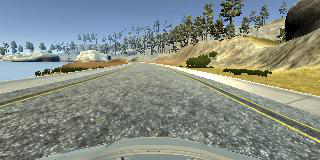

In [8]:
# Open image
image = Image.open(random_image_path)
image

# Transform Explore

## Preprocessing Images

In [739]:
# gray_image = TF.rgb_to_grayscale(image)
# gray_image

In [9]:
print(f"Image height: {image.height}") 
print(f"Image width: {image.width}")

Image height: 160
Image width: 320


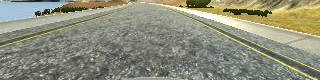

In [10]:
preprocessed_image = TF.crop(image,
                       top=60, 
                       left=0, 
                       height=80,
                       width=320)

preprocessed_image

In [742]:
print(f"Image height: {preprocessed_image.height}")
print(f"Image width: {preprocessed_image.width}")

Image height: 80
Image width: 320


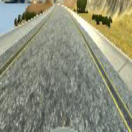

In [11]:
preprocessed_image = TF.resize(preprocessed_image, (128, 128), antialias=True)
preprocessed_image

## Random Transforms

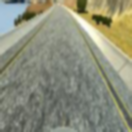

In [12]:
TF.gaussian_blur(preprocessed_image, kernel_size=5)

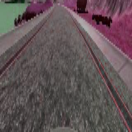

In [14]:
jitter = T.ColorJitter(brightness=.5, hue=.3, contrast=0.1, saturation=0.4)
jitter(preprocessed_image)

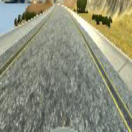

In [15]:
sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=4)
sharpness_adjuster(preprocessed_image)

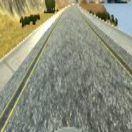

In [16]:
TF.hflip(preprocessed_image)

# Transforms

In [1]:
train_transform = T.Compose([
    T.RandomCrop((128, 128)),
    T.RandomAdjustSharpness(sharpness_factor=4, p=0.7),
    T.RandomAutocontrast(p=0.3),
    T.ColorJitter(brightness=0.3, hue=0.1, contrast=0.2, saturation=0.4),
    T.GaussianBlur(kernel_size=3),
])

NameError: name 'T' is not defined

In [18]:
x = T.PILToTensor()(preprocessed_image) # does not scale values to 0 and 1
x.shape, x.dtype

torch.Size([3, 132, 132])

In [19]:
x = train_transform(x)
x.shape, x.dtype

torch.Size([3, 128, 128])

In [22]:
x[0, 0, :5]

tensor([126, 126, 123, 104,  78], dtype=torch.uint8)

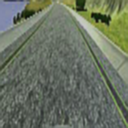

In [23]:
TF.to_pil_image(x)

# Normalization

In [28]:
x = (x / 127.5) - 1
x[0, 0, :5]

tensor([-0.0118, -0.0118, -0.0353, -0.1843, -0.3882])

In [25]:
x.dtype

torch.float32

In [26]:
x = ( x + 1 ) * 127.5
x = x.type(torch.uint8)
x[0, 0, :5]

tensor([126, 126, 123, 104,  78], dtype=torch.uint8)

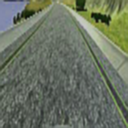

In [27]:
TF.to_pil_image(x)